<a href="https://colab.research.google.com/github/sayakpaul/Multimodal-Entailment-Baseline/blob/main/multimodal_entailment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In today's world information is mostly found in unstructured or semi-structured form as videos, texts, images, audios, etc. Therefore, to capture their inter-relationships we need to allow deep models take multimodal inputs i.e. text, images, etc. On social media platforms, to audit and moderate content we often need to find answers to the following questions in near real-time:

* Does a given piece of information contradict the other?
* Does a given piece of information imply the other?

In NLP, this task is referred to as recognizing textual entailment that only deals with texts as inputs. But in this case, we can have different inputs modalities. In this example, we will build and train a model for predicting multimodal entailment. We will be using the [multimodal entailment dataset](https://github.com/google-research-datasets/recognizing-multimodal-entailment) recently introduced by Google Research.

This example requires TensorFlow 2.5 or higher. In addition, TensorFlow Hub and TensorFlow Text are required for the BERT model ([Devlin et al.](https://arxiv.org/abs/1810.04805)). These libraries can be installed using the following command:

In [ ]:
!pip install -q tensorflow_text

     |████████████████████████████████| 4.3 MB 4.0 MB/s 


## Collect the dataset

The original dataset is available [here](https://github.com/google-research-datasets/recognizing-multimodal-entailment). However, we will be using a better prepared version of the dataset. Thanks to [Nilabhra Roy Chowdhury](https://de.linkedin.com/in/nilabhraroychowdhury) who worked on the preparation. 

In [ ]:
!wget -q https://github.com/sayakpaul/Multimodal-Entailment-Baseline/releases/download/v1.0.0/tweet_images.tar.gz
!tar xf tweet_images.tar.gz

## Imports

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras

## Define a label map

In [ ]:
label_map = {
    "Contradictory": 0,
    "Implies": 1,
    "NoEntailment": 2
}

## Read the dataset and apply basic preprocessing

In [ ]:
df = pd.read_csv("https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/tweets.csv")
df.sample(10)

,id_1,text_1,image_1,id_2,text_2,image_2,label
1010,1335849355752865797,Best Online Auction Software Available At Migr...,http://pbs.twimg.com/media/Eonj0FfVEAI4t0x.jpg,1343822454968336387,Find the Best eBay Bid Software To Create Mark...,http://pbs.twimg.com/media/EqY3XRyU8AERtTw.jpg,NoEntailment
101,1378719986378768386,Today is not about bunnies or baskets or eggs....,http://pbs.twimg.com/media/EyIyhViWEAI0wcx.jpg,1378790763593617409,"Happy Easter, everyone! https://t.co/O450IpPKO4",http://pbs.twimg.com/media/EyJy5GgXIAIvcph.jpg,NoEntailment
349,1344341983536549889,PODCAST: Your Sports Fix is back at it again w...,http://pbs.twimg.com/media/EqTTfWpXMAALODr.png,1382121673923629058,PODCAST: Your Sports Fix is back at it again w...,http://pbs.twimg.com/media/EyzZAu4XMAIAJsD.png,Implies
523,1358498852815388696,"We end the set on 5-1 run, but UAB will lead a...",http://pbs.twimg.com/media/EtpbfdLXIAEMcSH.jpg,1358510258872864781,UAB leads the set 2-1. https://t.co/To1MQMbgCB,http://pbs.twimg.com/media/Etpl3GmXEAEGrNu.jpg,NoEntailment
466,1357240852939218946,#IndiaFightsCorona:\n\nNearly 4.5 million bene...,http://pbs.twimg.com/media/EtXgrKrXcAI7nzk.jpg,1357547816629936129,#IndiaFightsCorona:\n\nIndia has become the fa...,http://pbs.twimg.com/media/EtX_T8HVoAA3Ngj.png,NoEntailment
781,1364507582484914176,"Always take them aside, explain why you're dis...",http://pbs.twimg.com/media/Eu-0agSXYAAYazX.jpg,1379730604141506561,Most managers have a method of calling for qui...,http://pbs.twimg.com/media/EyXJqw-WEAAv9ip.jpg,NoEntailment
670,1356330489527853056,#SPX500 SSI is at -1.76\n\nRisk Warning: Losse...,http://pbs.twimg.com/media/EtKnZJoXUAARsQw.png,1377161273830305800,#USOil SSI is at -1.25\n\nRisk Warning: Losses...,http://pbs.twimg.com/media/Exyo4X4VcAgVjQa.png,NoEntailment
960,1381602920399953921,Latest observations around the Perth area http...,http://pbs.twimg.com/media/EyxwZ_hU4AQUoyp.png,1381752124845924354,Latest observations around the Perth area http...,http://pbs.twimg.com/media/Eyz4OdwVoAEZ4ql.png,NoEntailment
864,1377960594595311619,"Team for GW30 not locked 🔒 \n\n🔹 Martinez OUT,...",http://pbs.twimg.com/media/Ex9_20jWgAMWbZw.jpg,1380567797961474055,🔒 #Wildcard team for #FPL #GW31 🔒\n\nGone fair...,http://pbs.twimg.com/media/EyjCpzkWEAYO8OE.jpg,NoEntailment
338,1355759912408686597,The Reception of the French Ambassador in Veni...,http://pbs.twimg.com/media/EtB7IfxXAAcPpMm.jpg,1359146144824233985,Reception of the Ambassador in the Doge's Pala...,http://pbs.twimg.com/media/EtyoN0pWQAsGW_O.jpg,NoEntailment


The columns we are interested in are the following:

* `text_1`
* `image_1`
* `text_2`
* `image_2`
* `label`

The entailment task is formulated as the following:

***Given the pairs of (`text_1`, `image_1`) and (`text_2`, `image_2`) do they entail (or not entail or contradict) each other?*** 

We have the images already downloaded. `image_1` is downloaded as `id1` as its filename and `image2` is downloaded as `id2` as its filename. In the next step, we will add two more columns to `df` - filepaths of `image_1`s and `image_2`s. 

In [ ]:
images_one_paths = []
images_two_paths = []

for idx in range(len(df)):
    current_row = df.iloc[idx]
    id_1 = current_row["id_1"]
    id_2 = current_row["id_2"]
    extentsion_one = current_row["image_1"].split(".") [-1]
    extentsion_two = current_row["image_2"].split(".") [-1]
    
    image_one_path = os.path.join("tweet_images", str(id_1) + f".{extentsion_one}")
    image_two_path = os.path.join("tweet_images", str(id_2) + f".{extentsion_two}")

    images_one_paths.append(image_one_path)
    images_two_paths.append(image_two_path)

In [ ]:
df["image_1_path"] = images_one_paths
df["image_2_path"] = images_two_paths

In [ ]:
# Create another column containing the integer ids of 
# the string labels.
df["label_idx"] = df["label"].apply(lambda x: label_map[x])

## Dataset visualization

In [ ]:
def visualize(idx):
    current_row = df.iloc[idx]
    image_1 = plt.imread(current_row["image_1_path"])
    image_2 = plt.imread(current_row["image_2_path"])
    text_1 = current_row["text_1"]
    text_2 = current_row["text_2"]
    label = current_row["label"]

    plt.subplot(1, 2, 1)
    plt.imshow(image_1)
    plt.axis("off")
    plt.title("Image One")
    plt.subplot(1, 2, 2)
    plt.imshow(image_1)
    plt.axis("off")
    plt.title("Image Two")
    plt.show()

    print(f"Text one: {text_1}")
    print(f"Text two: {text_2}")
    print(f"Label: {label}")

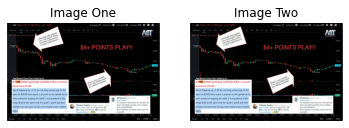

Text one: IN TODAY'S RE-CAP FOR 2/02/2020 FROM PRE-MARKET NOTES

$INO
WHAT A BEAUTIFUL WELL EXECUTED NOTES IN PRE-MARKET FOR EVERYONE TO ENJOY

TODAY, I WANTED TO SHORT THE GAP-UP ON $INO, SIMPLE EASY SHORT IDEA
I WANTED $17
WE GOT $14 ON IT

HIT $19
HIT $15
+5 PTS

https://t.co/akgUIWyiD3 https://t.co/kbEOpEUlDM
Text two: IN TODAY'S RE-CAP FOR 2/02/2020 FROM PRE-MARKET NOTES

$IMVT
WHAT A BEAUTIFUL WELL EXECUTED NOTES IN PRE-MARKET FOR EVERYONE TO ENJOY

TODAY, I WANTED TO LONG $IMVT AT $18
FELT THE CLINICAL HOLD WAS NEGATIVE BUT SHORTS WOULD COVER

HIT $18
HIT $28
+10 PTS

https://t.co/akgUIWyiD3 https://t.co/YdoDxYSdZD
Label: NoEntailment


In [ ]:
random_idx = np.random.choice(len(df))
visualize(random_idx)

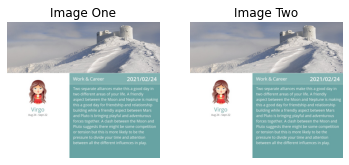

Text one: Work &amp; Career Horoscope for Feb 24, 2021 =&gt; Read the rest at: https://t.co/joetHxGcyH How did we do? #Virgo #VirgoCareer #VirgoLife https://t.co/5knBtPw3sQ
Text two: Love Horoscope for Feb 24, 2021 =&gt; Read the rest at: https://t.co/IaqtUL5YNy How did we do? #Virgo #VirgoLove #VirgoNation https://t.co/1ZVuHb5f1L
Label: NoEntailment


In [ ]:
random_idx = np.random.choice(len(df))
visualize(random_idx)

## Train/test split

The dataset suffers from [class imbalance problem](https://developers.google.com/machine-learning/glossary#class-imbalanced-dataset). We can confirm that in the following cell.

In [ ]:
df["label"].value_counts()

NoEntailment     1182
Implies           109
Contradictory     109
Name: label, dtype: int64

To account for that we will go for a stratified split. 

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.15, 
                                     stratify=df["label"].values, random_state=42)
print(f"Total training examples: {len(train_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 1190
Total test examples: 210


## Data input pipeline

TensorFlow Hub [provides](https://www.tensorflow.org/text/tutorials/bert_glue#loading_models_from_tensorflow_hub) a variety of BERT family of models. Each of those models comes with a corresponding preprocessing layer. You can know more about these models and the preprocessing layers from [here](https://www.tensorflow.org/text/tutorials/bert_glue#loading_models_from_tensorflow_hub). 

To keep the runtime of this example relatively shorter we will use a smaller variant of the original BERT model. 

In [ ]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

Our text preprocessing code mostly comes from [this tutorial](https://www.tensorflow.org/text/tutorials/bert_glue). You are highly encouraged to check out this tutorial to know more about the input preprocessing. 

In [ ]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(bert_preprocess_path)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return keras.Model(input_segments, model_inputs)

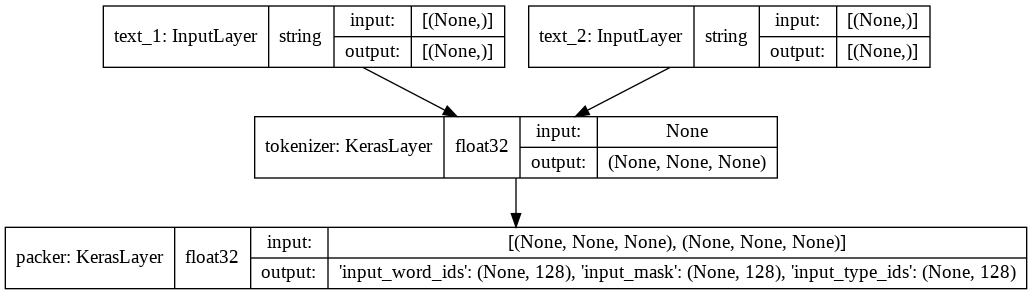

In [ ]:
bert_preprocess_model = make_bert_preprocess_model(['text_1', 'text_2'])
keras.utils.plot_model(bert_preprocess_model, show_shapes=True, show_dtype=True)

### Run the preprocessor on a sample input

In [ ]:
idx = np.random.choice(len(train_df))
row = train_df.iloc[idx]
sample_text_1, sample_text_2 = row["text_1"], row["text_2"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

Text 1: What’s your favorite source of healthy fat? #Nuts #DarkChocolate #ChiaSeeds #Avocado https://t.co/V5wwFjlOyu
Text 2: What’s your favorite source of healthy fat? #Nuts #DarkChocolate #ChiaSeeds #Avocado https://t.co/PB39sl1vvQ


In [ ]:
test_text = [np.array([sample_text_1]),
    np.array([sample_text_2])]
text_preprocessed = bert_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_word_ids', 'input_mask', 'input_type_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[  101  2054  1521  1055  2115  5440  3120  1997  7965  6638  1029  1001
 12264  1001  2601  9905], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


### Create `tf.data.Dataset` objects

We will now create `tf.data.Dataset` objects from the dataframes for performance.

Note that the text inputs will be preprocessed as a part of the data input pipeline. But the preprocessing modules can also be a part of their corresponding BERT models. This helps reduce the training/serving skew and lets our models operate with raw text inputs. Follow [this tutorial](https://www.tensorflow.org/text/tutorials/classify_text_with_bert) to know more about how to incorporate the preprocessing modules directly inside the models. 

In [ ]:
def dataframe_to_dataset(dataframe):
    columns = ["image_1_path", "image_2_path", "text_1", "text_2", "label_idx"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label_idx")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    return ds

train_ds = dataframe_to_dataset(train_df)
test_ds = dataframe_to_dataset(test_df)

### Preprocessing utilities

In [ ]:
resize = (128, 128)
bert_input_features = ['input_word_ids', 'input_type_ids', 'input_mask']

def read_resize(image_path):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, resize)
    return image

def preprocess_text(text_1, text_2):
    text_1 = tf.convert_to_tensor([text_1])
    text_2 = tf.convert_to_tensor([text_2])
    output = bert_preprocess_model([text_1, text_2])
    output = {feature: tf.squeeze(output[feature]) 
        for feature in bert_input_features}
    return output

def preprocess(sample):
    image_1 = read_resize(sample["image_1_path"])
    image_2 = read_resize(sample["image_2_path"])
    text = preprocess_text(sample["text_1"], sample["text_2"])
    return {"image_1": image_1, "image_2": image_2, "text": text}

### Create the final datasets

In [ ]:
batch_size = 32
auto = tf.data.AUTOTUNE

def prepare_dataset(ds, training=True):
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess(x), y))
    ds = ds.batch(batch_size).prefetch(auto)
    return ds

In [ ]:
train_ds = prepare_dataset(train_ds)
test_ds = prepare_dataset(test_ds, False)

In [ ]:
# Reference:
# https://www.tensorflow.org/neural_structured_learning/tutorials/graph_keras_lstm_imdb
validation_fraction = 0.9
validation_size = int(validation_fraction *
                      int(len(train_df) / batch_size))
print(f"Validation samples: {validation_size}")
validation_ds = train_ds.take(validation_size)
train_ds = train_ds.skip(validation_size)

Validation samples: 33


## Model building utilities

Our final model will accept two images along with their text counterparts. While the images will be directly fed to the model the text inputs will first be preprocessed and then will make it to the model. Below is a pictorial depiction of this approach:

![](https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/figures/brief_architecture.png)

The model consists of the following elements:

* A standalone encoder for the images. We will use a [ResNet50V2](https://arxiv.org/abs/1603.05027) pre-trained on the ImageNet-1k dataset for this.
* A stanalone encoder for the images. A pre-trained BERT will be used for this. 

After extracting the individual embeddings, they will be projected in an identical space. Finally, their projections will be concatenated and be fed to the final classification layer. 

This is a multi-class classification problem involving the following classes:

* NoEntailment     
* Implies           
* Contradictory     

`project_embeddings()`, `create_vision_encoder()`, and `create_text_encoder()` utilities are referred from [this example](https://keras.io/examples/nlp/nl_image_search/). 

In [ ]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

In [ ]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.ResNet50V2(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable
    
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")
    
    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    preprocessed_2 = keras.applications.resnet_v2.preprocess_input(image_2)
    
    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings_1 = resnet_v2(preprocessed_1)
    embeddings_2 = resnet_v2(preprocessed_2)
    embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])
    
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1, image_2], outputs, name="vision_encoder")

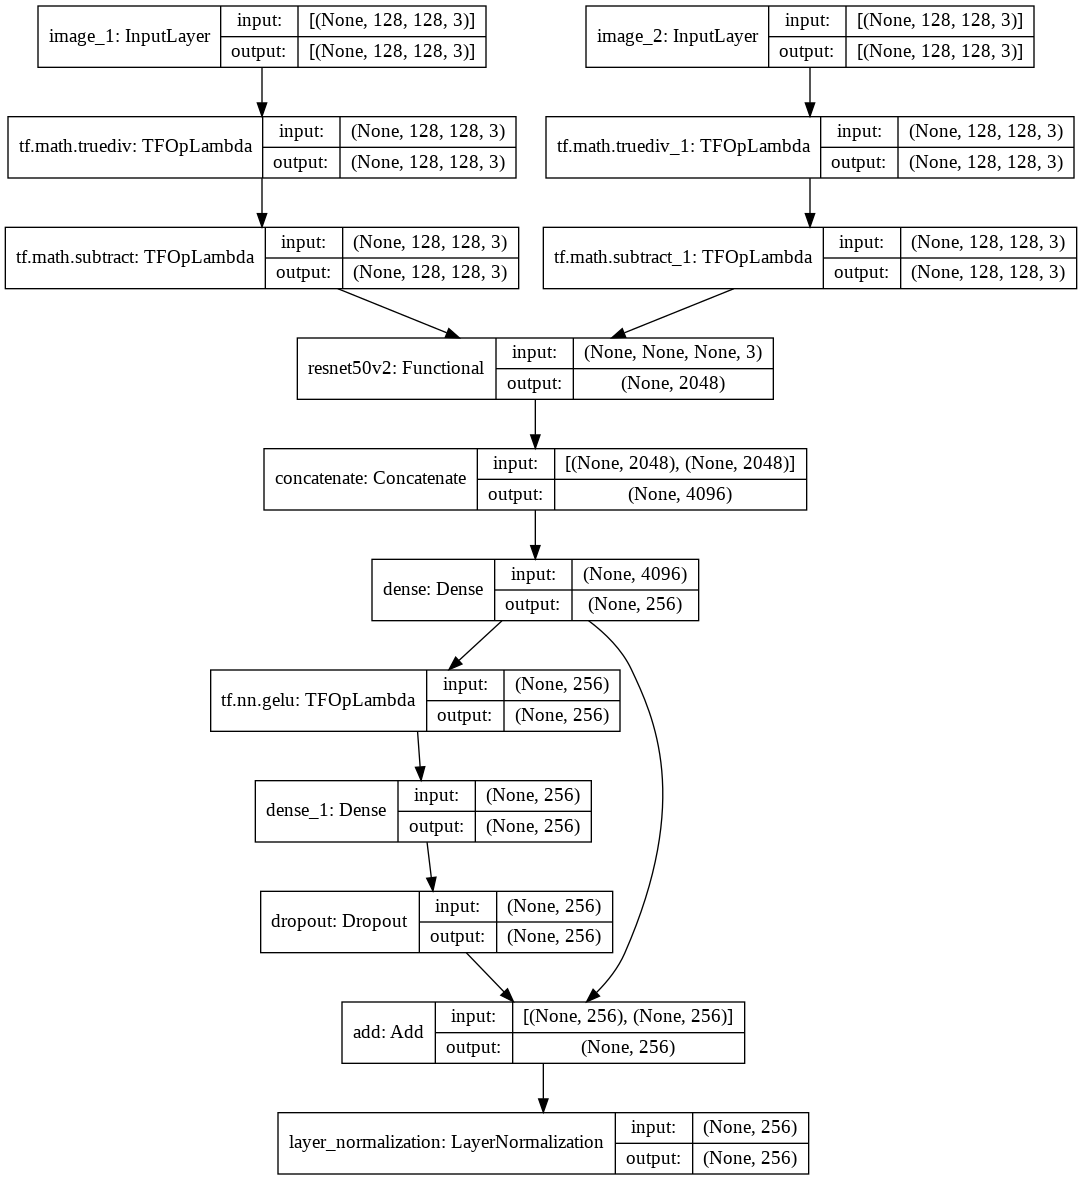

In [ ]:
vision_encoder = create_vision_encoder(num_projection_layers=1, projection_dims=256, dropout_rate=0.1)
keras.utils.plot_model(vision_encoder, show_shapes=True)

In [ ]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(
        bert_model_path,
        name="bert",
    )
    # Set the trainability of the base encoder.
    bert.trainable = trainable
    
    # Receive the text as inputs.
    bert_input_features = ['input_type_ids', 'input_mask', 'input_word_ids']
    inputs = {
        feature: keras.Input(shape=(128, ), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }
    
    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]
    
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

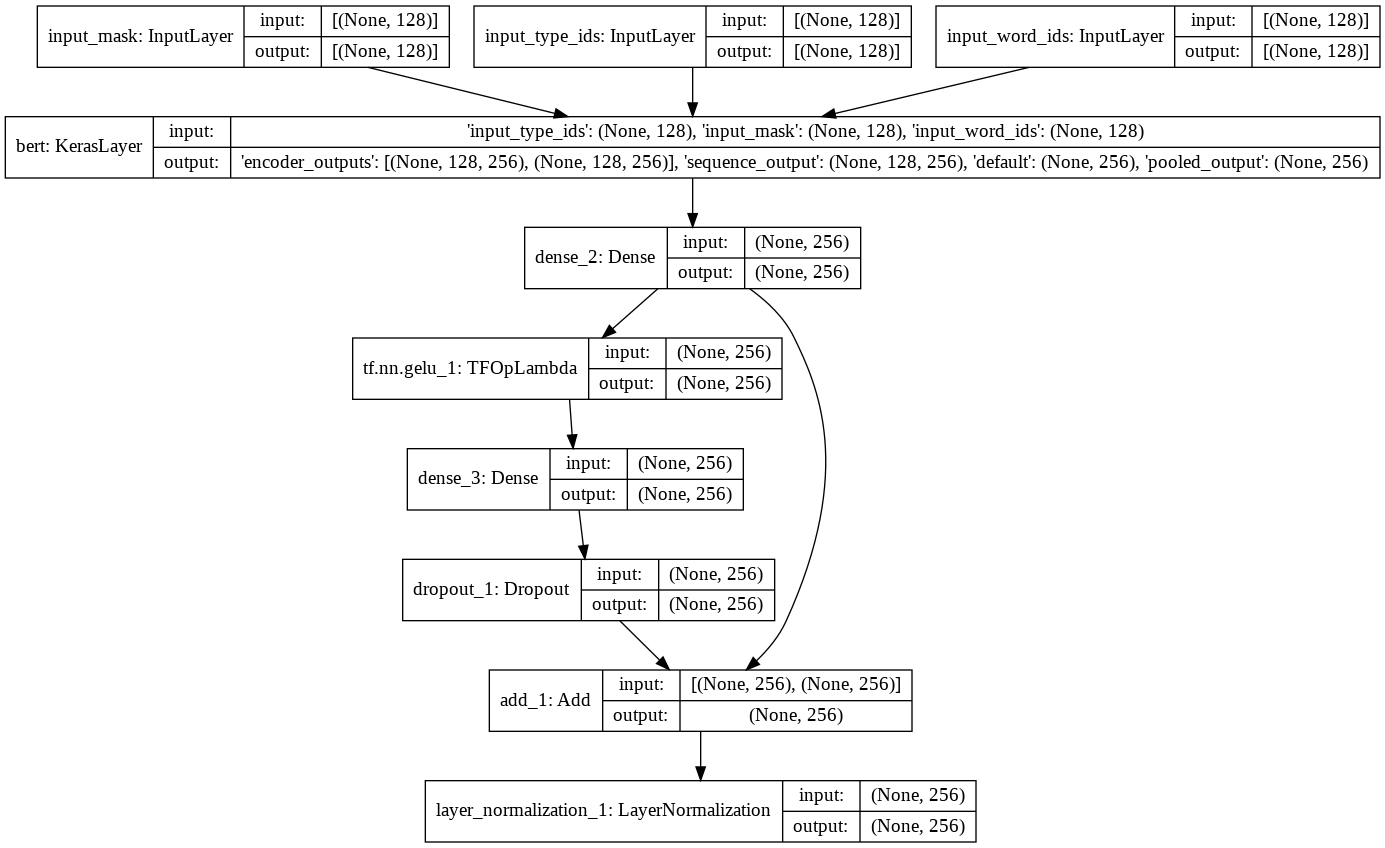

In [ ]:
text_encoder = create_text_encoder(num_projection_layers=1, projection_dims=256, dropout_rate=0.1)
keras.utils.plot_model(text_encoder, show_shapes=True)

In [ ]:
def create_multimodal_model(num_projection_layers=1, projection_dims=256, dropout_rate=0.1, 
                     vision_trainable=False, text_trainable=False):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")

    # Receive the text as inputs.
    bert_input_features = ['input_type_ids', 'input_mask', 'input_word_ids']
    text_inputs = {
        feature: keras.Input(shape=(128, ), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    vision_encoder = create_vision_encoder(num_projection_layers, projection_dims, dropout_rate, vision_trainable)
    text_encoder = create_text_encoder(num_projection_layers, projection_dims, dropout_rate, text_trainable)

    # Fetch the embedding projections.
    vision_projections = vision_encoder([image_1, image_2])
    text_projections = text_encoder(text_inputs)

    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    outputs = keras.layers.Dense(3, activation="softmax")(concatenated)
    return keras.Model([image_1, image_2, text_inputs], outputs)

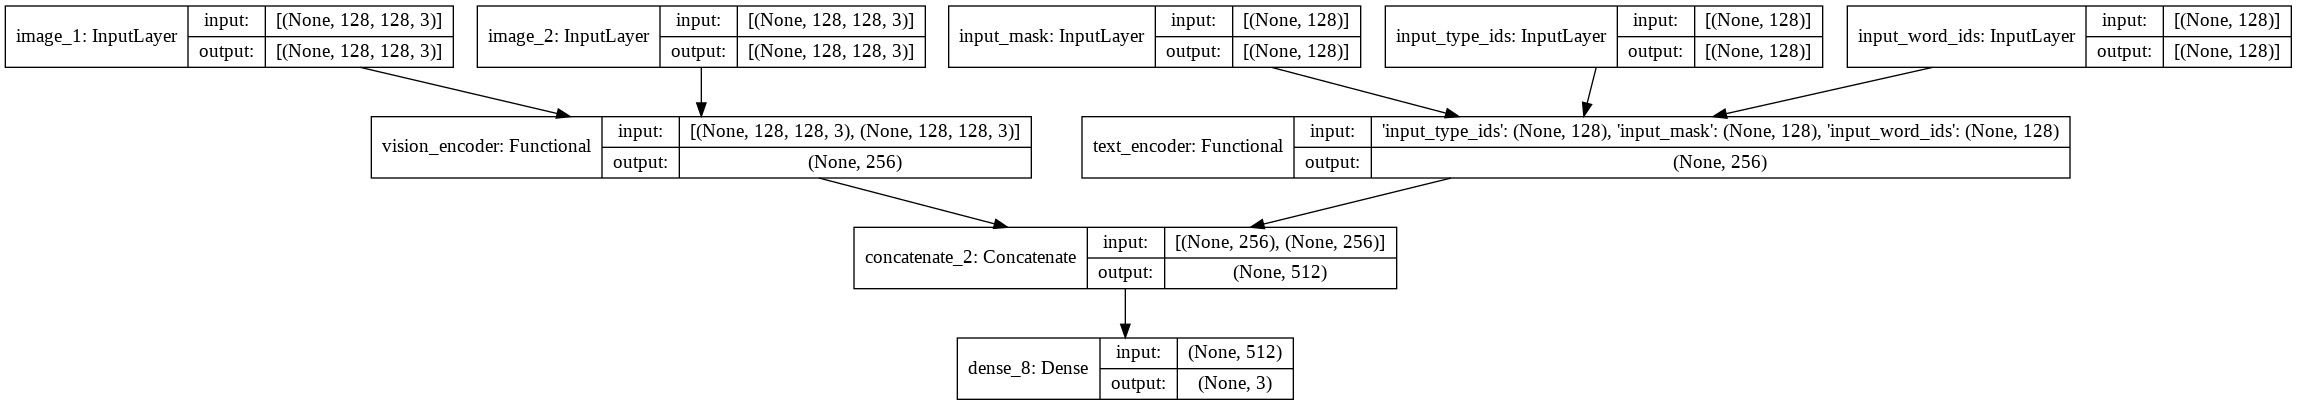

In [ ]:
multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True)

You are encouraged to play with the different hyperparameters involved in building this model and observe how the final performance is affected. 

## Compile and train the model

In [ ]:
multimodal_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [ ]:
history = multimodal_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10
)

Epoch 1/10
5/5 [==============================] - 47s 4s/step - loss: 1.8292 - accuracy: 0.7537 - val_loss: 1.7338 - val_accuracy: 0.8466
Epoch 2/10
5/5 [==============================] - 26s 4s/step - loss: 1.1093 - accuracy: 0.9179 - val_loss: 1.3601 - val_accuracy: 0.8797
Epoch 3/10
5/5 [==============================] - 26s 3s/step - loss: 1.2026 - accuracy: 0.8955 - val_loss: 0.6711 - val_accuracy: 0.8807
Epoch 4/10
5/5 [==============================] - 26s 3s/step - loss: 0.7443 - accuracy: 0.8060 - val_loss: 0.8074 - val_accuracy: 0.5985
Epoch 5/10
5/5 [==============================] - 26s 3s/step - loss: 0.6331 - accuracy: 0.7910 - val_loss: 0.5276 - val_accuracy: 0.8788
Epoch 6/10
5/5 [==============================] - 26s 3s/step - loss: 0.3327 - accuracy: 0.9254 - val_loss: 0.5630 - val_accuracy: 0.8665
Epoch 7/10
5/5 [==============================] - 26s 3s/step - loss: 0.6295 - accuracy: 0.8582 - val_loss: 0.4406 - val_accuracy: 0.8816
Epoch 8/10
5/5 [==================

## Evaluate the model

In [ ]:
_, acc = multimodal_model.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

7/7 [==============================] - 3s 349ms/step - loss: 0.5407 - accuracy: 0.8667
Accuracy on the test set: 86.67%.


## Notes

* We used a smaller variant of the original BERT model. Chances are likely that with a larger variant, this performance will be improved. TensorFlow Hub [provides](https://www.tensorflow.org/text/tutorials/bert_glue#loading_models_from_tensorflow_hub) a number of different BERT models that you can experiment with.
* The dataset suffers from class imbalance. If we had used a weighted loss then the training would have been more guided. You can check out this tutorial to know more about handling [imbalanced datasets](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data). 
* We kept the pre-trained models frozen. Fine-tuning them on the multimodal entailment task would have resulted in a better performance.
* We built a simple baseline model for the multimodal entailment task. There are various approaches that have been proposed to tackle the entailment problem. [This presentation deck](https://docs.google.com/presentation/d/1mAB31BCmqzfedreNZYn4hsKPFmgHA9Kxz219DzyRY3c/edit?usp=sharing) from the [Recognizing Multimodal Entailment](https://multimodal-entailment.github.io/) tutorial provides a comprehensive overview. 